# Shor's algorithm in Qiskit


## uwaga o rekomendowanym symulatorze
Ze względu na wiele qbitów i długie obwody - obecnie kod jest skonfigurowany do współpracy z wysokowydajnym symulatorem qiskit-air  

https://github.com/Qiskit/qiskit-aer

Przed uruchomieniem notebooka upewnij się, że  jest on zainstalowany (był opcjonalny do zainstalowania w notebooku wprowadzającym do laboratorium 3)

<code>!pip install qiskit-aer</code>

Poniższy notebook  został sprawdzony  z wersjami oprogramowania jak poniżej. 

Najprościej uruchamiać go:
* w tym samym środowsku co lab3
* z tego katalogu, w którym jest, wraz z całym repozytorium (aby mógł zaimportować implementację algorytmu Shora)

In [1]:
import qiskit_aer
qiskit_aer.version.get_version_info()

'0.17.0'

In [2]:
import qiskit
qiskit.version.get_version_info()

'1.4.2'

## Preparations

In [3]:
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

from qiskit.visualization import plot_histogram

In [4]:
import sys
import logging

logging.basicConfig(level=logging.INFO)

for handler in logging.getLogger().handlers:
    handler.setLevel(logging.WARNING)

logger = logging.getLogger('implementations.shor')
logger.setLevel(logging.INFO)

if len(logger.handlers) == 0:
    handler = logging.StreamHandler(sys.stdout)
    handler.setLevel(logging.INFO)
    handler.setFormatter(logging.Formatter('%(name)s: %(message)s'))
    handler.addFilter(logging.Filter('implementations.shor'))
    logger.addHandler(handler)

Select numbers to test.

In [5]:
# N = 15, 21; also 35, 55 (for these, simulation will be longer, up to few minutes)
N = 15

# 1 < a < N and gcd(a, N) = 1
a = 7

## Classical calculations

Compute classically reminders of `a^x mod N` for `x = 1, ..., 20`. Present results on graph, observe the period. For modular power, see https://docs.python.org/3.8/library/functions.html#pow

In [6]:
exponents = list(range(20))
values = []

for i in exponents:
    value = pow(a, i, mod=N)
    values.append(value)

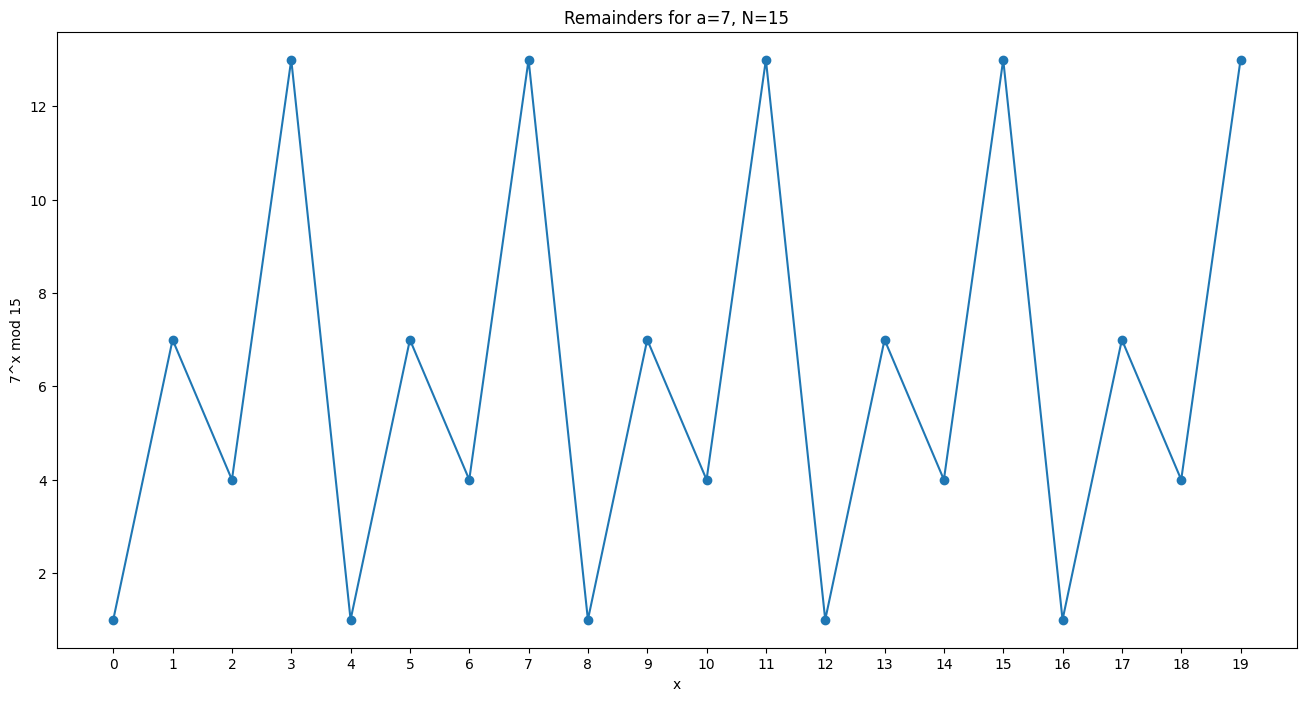

In [7]:
plt.figure(figsize=(16, 8))
plt.title(f'Remainders for a={a}, N={N}')
plt.xlabel('x')
plt.xticks(exponents)
plt.ylabel(f'{a}^x mod {N}')
plt.scatter(exponents, values)
plt.plot(exponents, values)
plt.show()

## Operation `a^x mod N` in Qiskit

Import gate for modular exponentiation. You can also use other implementations (mind the number of ancillary qubits).

In [8]:
from gates.mix.modular_exponentiation import modular_exponentiation_gate  # (n + 1 ancilla)

# from gates.takahashi.modular_exponentiation import modular_exponentiation_gate # (n + 1 ancilla)

# from gates.beauregard.modular_exponentiation import modular_exponentiation_gate # (n + 2 ancilla)

# from gates.haner.modular_exponentiation import modular_exponentiation_gate # (n + 1 ancilla, big size of circuit!)

Count width `n` of `N`.

In [9]:
n = N.bit_length()
print(n)

4


Create registers and circuit.

In [10]:
# input register
x_qreg = QuantumRegister(2 * n, name='x')

# output register, must contain 1
y_qreg = QuantumRegister(n, name='y')

In [11]:
# ancillary register; change the size according to selected implementation
ancillary_register_size = n + 1
aux_qreg = QuantumRegister(ancillary_register_size, name='aux')

In [12]:
circuit = QuantumCircuit(x_qreg, y_qreg, aux_qreg)

In [13]:
# prepare input register
circuit.h(x_qreg)

# prepare output register
circuit.x(y_qreg[0])

In [14]:
# append gate
gate = modular_exponentiation_gate(a, N, n)
circuit.append(gate, circuit.qubits)

In [15]:
# measure output register
y_creg = ClassicalRegister(n, name='yValue')
circuit.add_register(y_creg)
circuit.measure(y_qreg, y_creg)

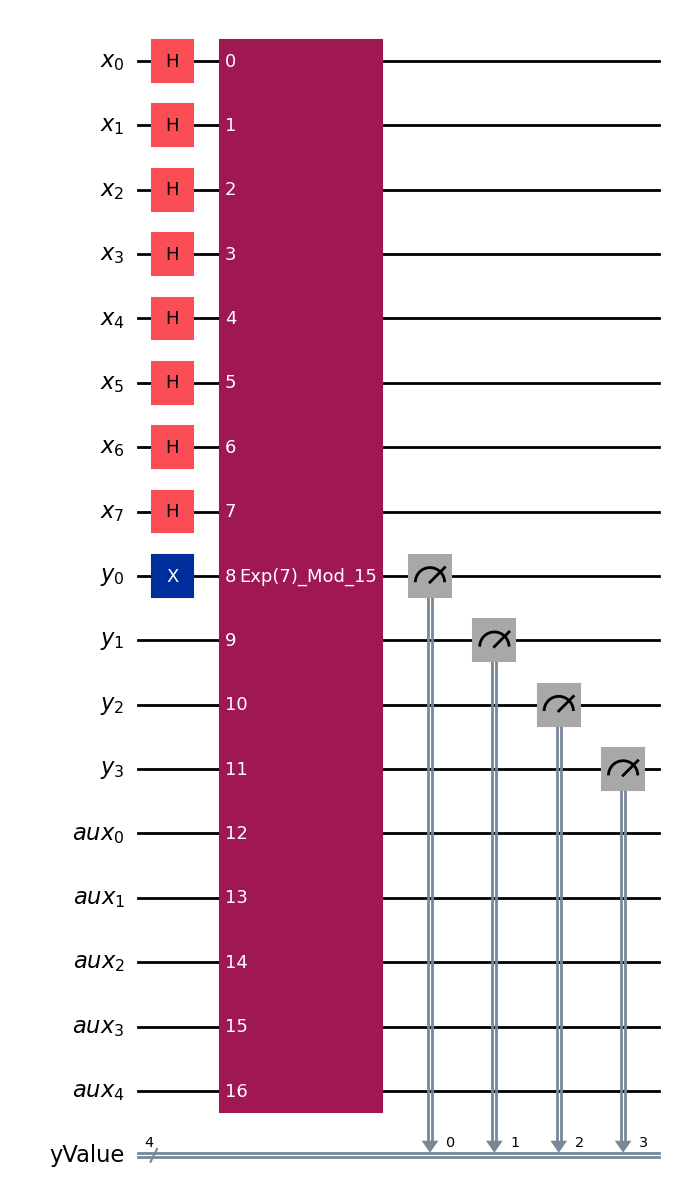

In [16]:
circuit.draw(output='mpl', fold=-1)

Run circuit using AerSimulator


In [17]:
import qiskit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
#Construct the simulator
aersim = AerSimulator()

In [18]:
pm = generate_preset_pass_manager(backend=aersim, optimization_level=3)
isa_qc = pm.run(circuit)
#run
result = aersim.run(isa_qc, shots=1024).result()
counts = result.get_counts(0)
print('Counts:', counts)

Counts: {'1101': 260, '0100': 259, '0001': 255, '0111': 250}


Draw histogram. Compare results with classical calculations.

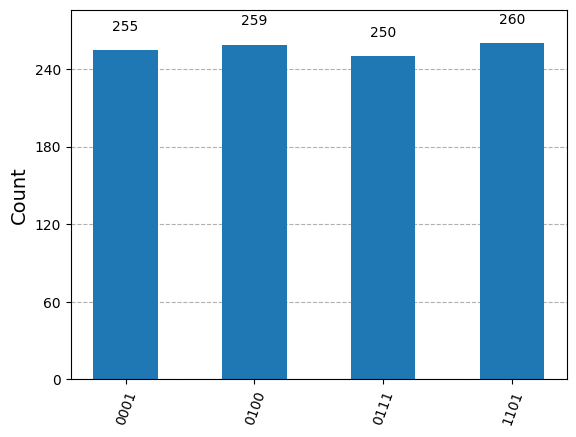

In [19]:
#counts = exponentiation_result.quasi_dists[0].binary_probabilities()
plot_histogram(counts)

Let's try observe period.

In [20]:
# clone circuit
circuit2 = circuit.copy()

# measure input register
x_creg = ClassicalRegister(2 * n, name='xValue')
circuit2.add_register(x_creg)
circuit2.measure(x_qreg, x_creg)

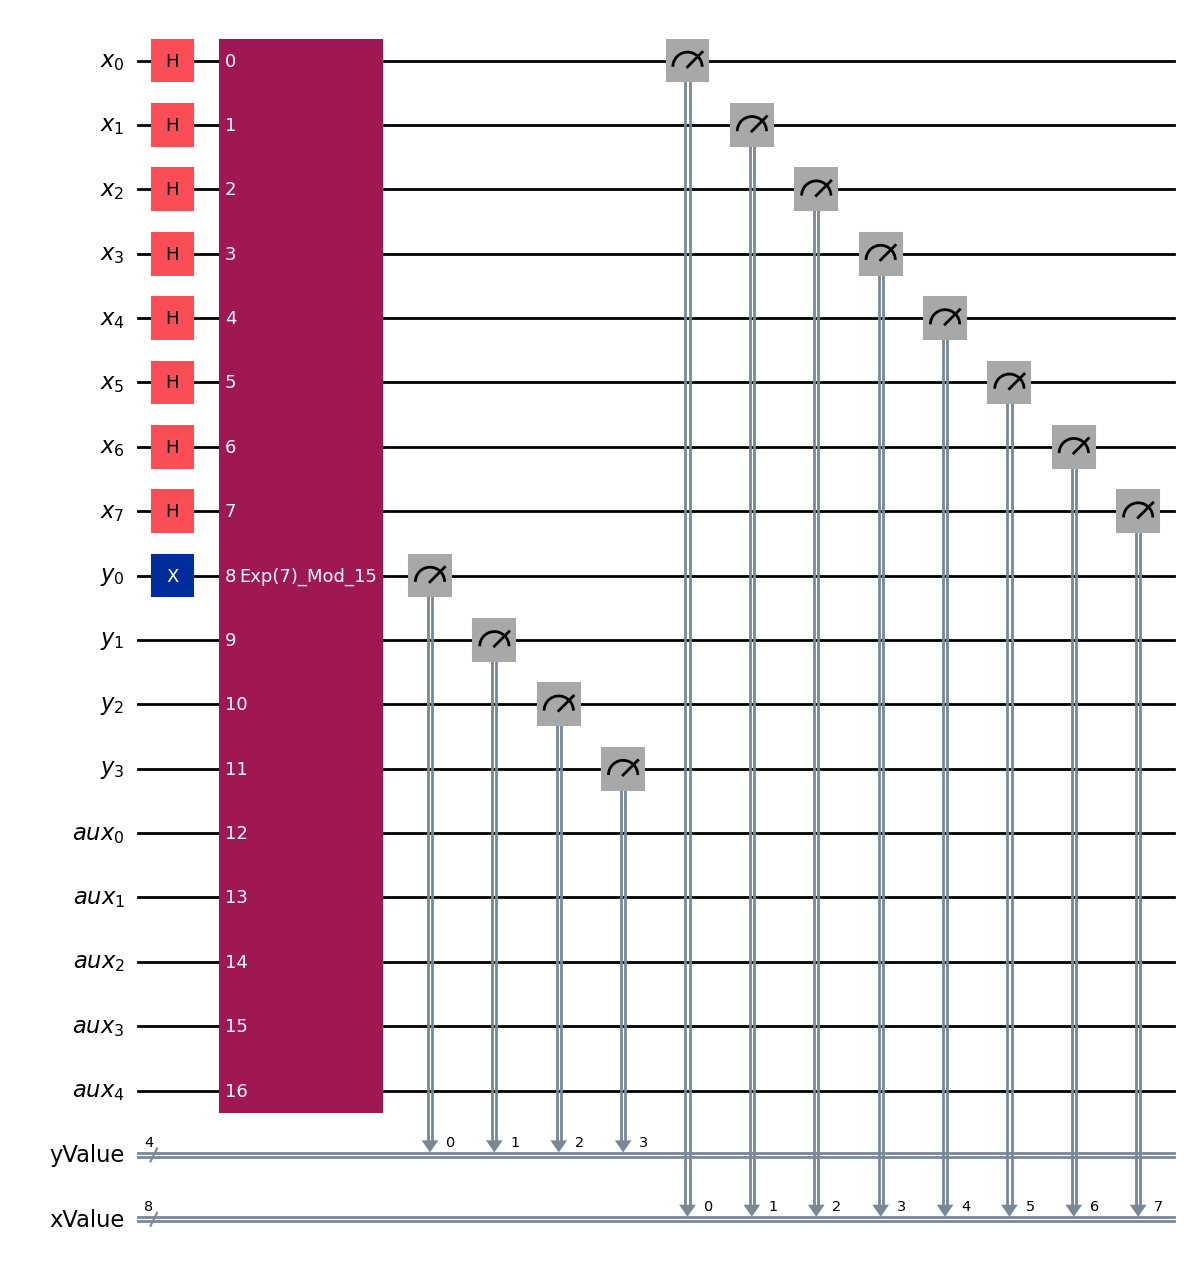

In [21]:
circuit2.draw(output='mpl', fold=-1)

In [22]:
pm = generate_preset_pass_manager(backend=aersim, optimization_level=3)
isa_qc = pm.run(circuit2)
result = aersim.run(isa_qc,shots=1024).result()
counts = result.get_counts(0)

In [23]:
values_map = {}
for measurement in counts.keys():
    s=2*n
    x=int(measurement[:s], base=2)
    y=int(measurement[s:], base=2)
    values = values_map.get(y, [])
    values.append(x)
    values_map[y] = values

Print measured `x` values for each exponentiation result.
You should observe that values differs from each other by constant - period `r`. (precisely, only part of them
in different runs will - think why!)

In [24]:
for y, x_values in values_map.items():
    print(y)
    print(sorted(x_values))
    print()

1
[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252]

13
[3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 79, 83, 87, 91, 95, 99, 103, 107, 111, 115, 119, 123, 127, 131, 135, 139, 143, 147, 151, 155, 159, 163, 167, 171, 175, 179, 183, 187, 191, 195, 199, 203, 207, 211, 215, 219, 223, 227, 231, 235, 239, 243, 247, 251, 255]

4
[2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, 66, 70, 74, 78, 82, 86, 90, 94, 98, 102, 106, 110, 114, 118, 122, 126, 130, 134, 138, 142, 146, 150, 154, 158, 162, 166, 170, 174, 178, 182, 186, 190, 194, 198, 202, 206, 210, 214, 218, 222, 226, 230, 234, 238, 242, 246, 250, 254]

7
[1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77, 81, 85, 89, 93, 97, 101, 105,

## Finding period / order in Qiskit

Import Shor's algorithm implementation.
Similarly to modular exponentiation gate, you can test different implementations.

In [25]:
from implementations.mix import MixShor as Shor

# from implementations.takahashi import TakahashiShor as Shor

# from implementations.beauregard import BeauregardShor as Shor

# from implementations.haner import HanerShor as Shor # (big size of circuit!)

For usage, class instance have to be created. The circuits will be run using local qiskit-air simulator.

In [26]:
# create instance of class
shor = Shor(shots=64)

Observe 3 parts of algorithm.

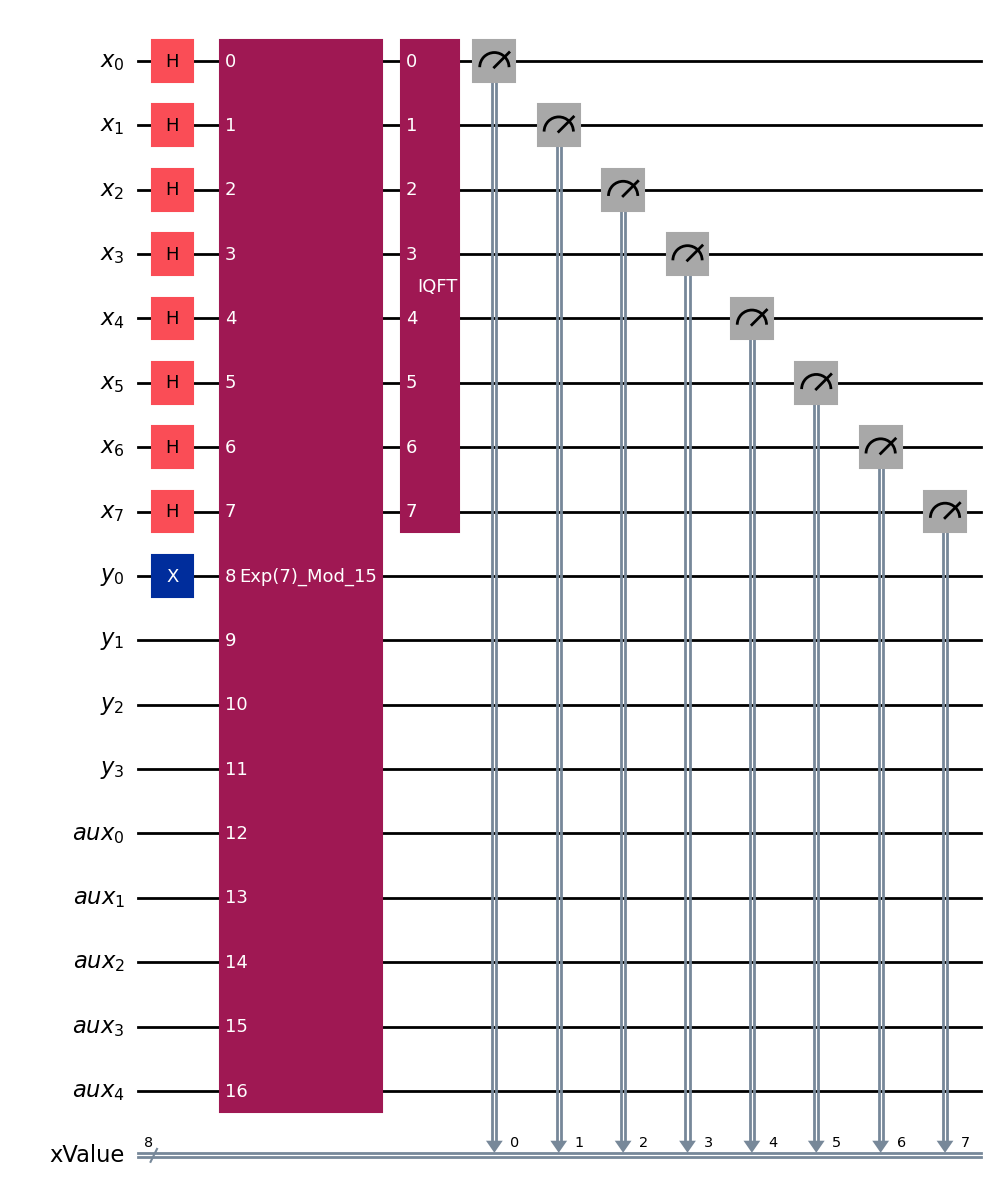

In [27]:
N=15
a=7
circuit = shor.construct_circuit(a, N, semi_classical=False, measurement=True)
circuit.draw(output='mpl', fold=-1)

Invoke `get_order()` to run algorithm and post-process measurements. 
<b>Setting `semi_classical` argument to `True` will run algorithm on optimized version of circuit.</b>

In [28]:
result = shor.get_order(a, N, semi_classical=True)

implementations.shor: Measurement = 64.
implementations.shor: Measured phase = 0.25.
implementations.shor: Fractional approximation: 1/4.
implementations.shor: Success, order: r = 4 from measurement 64.
implementations.shor: Measurement = 192.
implementations.shor: Measured phase = 0.75.
implementations.shor: Fractional approximation: 3/4.
implementations.shor: Success, order: r = 4 from measurement 192.
implementations.shor: Measurement = 128.
implementations.shor: Measured phase = 0.5.
implementations.shor: Fractional approximation: 1/2.
implementations.shor: Denominator 2 is not the order. Trying multiplication for case when numerator and denominator had a common factor.
implementations.shor: Success, order: r = 2*2 = 4.
implementations.shor: Measurement = 0, order is trivial: r = 1.
implementations.shor: Skip trivial order.


Print result. Compare it with earlier observed order.

In [29]:
print(result.total_shots, result.successful_shots)
print(result.total_counts, result.successful_counts)
print(result.order)

64 50
4 3
4


## Bob's and Eva's algorithm

Use `get_order()` to perform tasks from laboratories.
For modular power and modular inverse see: https://docs.python.org/3/library/functions.html#pow

### Eva's Algorithm

In [35]:
# dane wejściowe
b = 23
c = 7
N = 55

order = shor.get_order(b, N, semi_classical=True)

implementations.shor: Measurement = 1024.
implementations.shor: Measured phase = 0.25.
implementations.shor: Fractional approximation: 1/4.
implementations.shor: Success, order: r = 4 from measurement 1024.
implementations.shor: Measurement = 3072.
implementations.shor: Measured phase = 0.75.
implementations.shor: Fractional approximation: 3/4.
implementations.shor: Success, order: r = 4 from measurement 3072.
implementations.shor: Measurement = 0, order is trivial: r = 1.
implementations.shor: Skip trivial order.
implementations.shor: Measurement = 2048.
implementations.shor: Measured phase = 0.5.
implementations.shor: Fractional approximation: 1/2.
implementations.shor: Denominator 2 is not the order. Trying multiplication for case when numerator and denominator had a common factor.
implementations.shor: Success, order: r = 2*2 = 4.


In [36]:
r = order.order
dprim = pow(c, -1, r)
a = pow(b, dprim, N)
print(a)

12


### Bob's Algorithm

In [44]:
import random
import math

# dane wejściowe
b = 23
N = 55
c = 7

# znajdowanie rozkładu N na czynniki pierwsze za pomocą okresu r
def find_factors(N):
    while True:
        a = random.randint(2, N - 1)
        nwd = math.gcd(a, N)
        if 1 < nwd < N:
            p = nwd
            q = N // p
            return p, q

        order = shor.get_order(a, N, semi_classical=True)
        r = order.order

        if r % 2 == 1:
            continue

        another_nwd = math.gcd(pow(a, r // 2, N) + 1, N)
        if another_nwd == 1 or another_nwd == N:
            continue

        p = another_nwd
        q = N // p
        return p, q
    
p, q = find_factors(N)
G = (p - 1) * (q - 1)
d = pow(c, -1, G)
a = pow(b, d, N)
print(a)

implementations.shor: Measurement = 614.
implementations.shor: Measured phase = 0.14990234375.
implementations.shor: Fractional approximation: 3/20.
implementations.shor: Success, order: r = 20 from measurement 614.
implementations.shor: Measurement = 0, order is trivial: r = 1.
implementations.shor: Skip trivial order.
implementations.shor: Measurement = 3687.
implementations.shor: Measured phase = 0.900146484375.
implementations.shor: Fractional approximation: 9/10.
implementations.shor: Denominator 10 is not the order. Trying multiplication for case when numerator and denominator had a common factor.
implementations.shor: Success, order: r = 2*10 = 20.
implementations.shor: Measurement = 3891.
implementations.shor: Measured phase = 0.949951171875.
implementations.shor: Fractional approximation: 19/20.
implementations.shor: Success, order: r = 20 from measurement 3891.
implementations.shor: Measurement = 615.
implementations.shor: Measured phase = 0.150146484375.
implementations.shor

### Krótkie porównanie algorytmu Ewy i Boba

1. Łatwość implementacji:
    Algorytm Ewy jest łatwiejszy, ponieważ opiera się na okresie funkcji. Nie trzeba dodatkowo z okresu liczyć p i q.
2. Uniwersalność w stosunku do różnych wiadomości
    Algorytm Boba jest bardziej uniwersalny, ponieważ opiera się na p i q, a w przypadku algorytmu Ewy musimy znać okres z każdej wiadomości osobno.

### Wykres funkcji a^x mod N

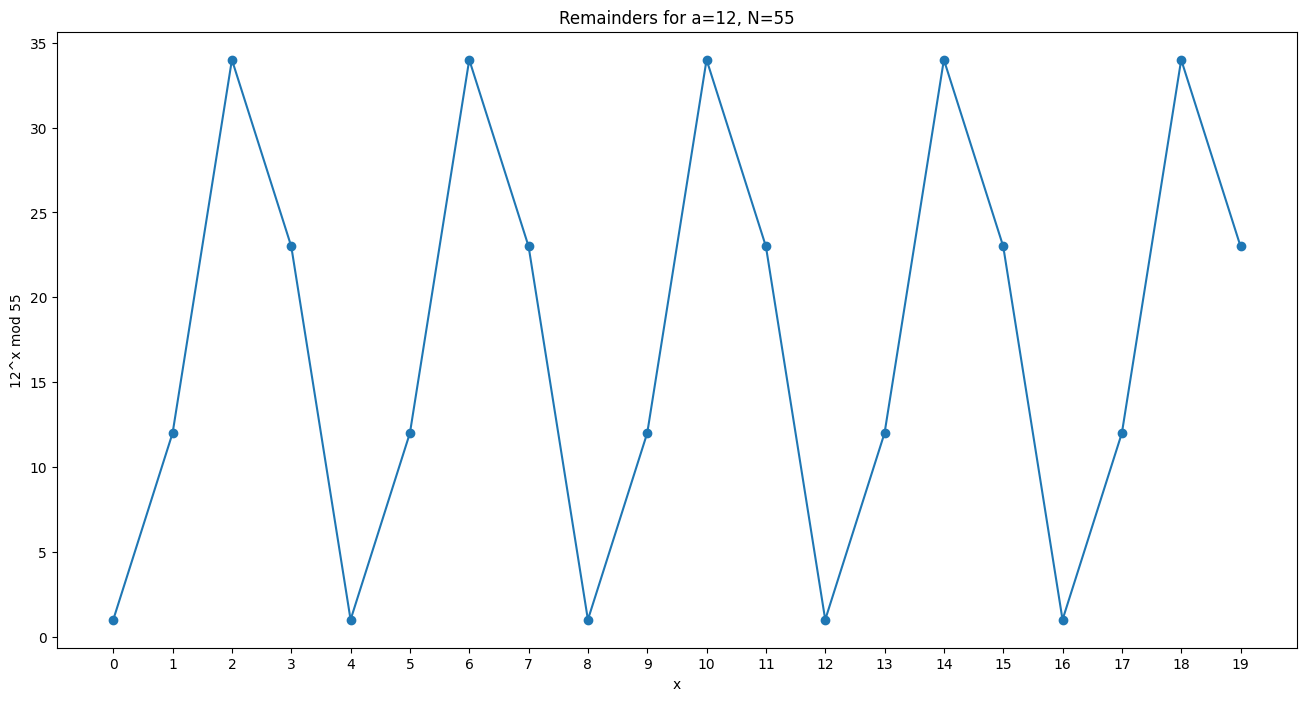

In [42]:
a = 12
N = 55

values = []
for i in range(20):
    value = pow(a, i, mod=N)
    values.append(value)
    
plt.figure(figsize=(16, 8))
plt.title(f'Remainders for a={a}, N={N}')
plt.xlabel('x')
plt.xticks(exponents)
plt.ylabel(f'{a}^x mod {N}')
plt.scatter(exponents, values)
plt.plot(exponents, values)
plt.show()

### Dlaczego ta funkcja jest istotna w algorytmie RSA?

Za pomocą właśnie tej funkcji odbywa się szyfrowanie i deszyfrowanie wiadomości.